# Analysis of digitized base circles

In [1]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from itertools import count
from pathlib import Path
import subsampling_config

/home/nialov/.local/share/virtualenvs/trace_repo-280iuCPs/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
import fractopo_scripts.simulation.utils as utils
import fractopo_scripts.simulation.plotting_utils as plotting_utils

In [3]:
sns.set_theme(context="paper", style="ticks", font_scale=1.3)

## Read data

In [4]:
analysis_points = gpd.read_file(subsampling_config.analysis_points_path)

/home/nialov/.local/share/virtualenvs/trace_repo-280iuCPs/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Data is filtered to only selected target areas, spatially concentrated. Neither radius or coverage filter affects this dataset.

In [5]:
filtered = utils.filter_dataframe(
    analysis_points,
    list(subsampling_config.circle_names_with_diameter),
    filter_radius=(5, 51),
    relative_coverage_threshold=0.11,
)

Name filtered: 7
Radius filtered: 0
Coverage filtered: 0


The maximum relative coverage is:

In [6]:
filtered[utils.Utils.relative_coverage].max()

0.10091961442281777

In [7]:
analysis_points.shape[0], filtered.shape[0]

(20, 13)

Shoreline dataset contains a rough sketch of the Getaberget shoreline for visualization purposes only.

In [8]:
#shoreline = gpd.read_file(subsampling_config.shoreline_geojson_url)
shoreline = gpd.read_file("/home/nialov/nikke-projects/Pipenv_projects/fractopo_scripts/misc/shoreline.geojson")

## Determine reference values for simulation analyses

The parameter values determined from the full dataset should represent the most accurate assesment.

Because the full circle radii vary, the achieved parameter results must be weighted by the area of the circle.

In [9]:
reference_values = {
    utils.param_renamer(param): round(
        np.average(filtered[param], weights=filtered["area"]), 4
    )
    for param in utils.Utils.params_with_func
    if param in utils.Utils.selected_params
}
# Save to local file
reference_value_df = pd.DataFrame(
    {"Parameter": reference_values.keys(), "Value": reference_values.values()}
)
reference_value_df.to_csv(subsampling_config.base_circle_reference_value_csv_path, index=False)

In [10]:
reference_value_df

,Parameter,Value
0,Connections per Branch,1.4435
1,Trace Power-law Exponent,-1.7546
2,Branch Power-law Exponent,-2.9051
3,Fracture Intensity P21,2.0089


Total area in base circles.

In [11]:
filtered["area"].sum()

20813.051330032384

## Spatial variance analysis of parameters

Do parameters have a direct correlation with their spatial location in E-W or N-S axes?

In [12]:
filtered["x"] = [point.x for point in filtered.geometry.values]
filtered["y"] = [point.y for point in filtered.geometry.values]

In [13]:
filtered["name"]

1     Getaberget_20m_1_1_area
2     Getaberget_20m_1_2_area
3     Getaberget_20m_1_3_area
4     Getaberget_20m_1_4_area
5     Getaberget_20m_2_1_area
6     Getaberget_20m_2_2_area
12    Getaberget_20m_4_3_area
13    Getaberget_20m_5_1_area
14    Getaberget_20m_7_1_area
15    Getaberget_20m_7_2_area
16    Getaberget_20m_8_3_area
17    Getaberget_20m_9_2_area
18      Havsvidden_20m_1_area
Name: name, dtype: object

<AxesSubplot:>

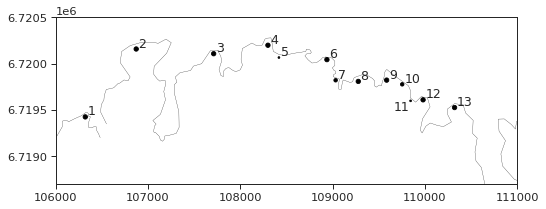

In [14]:
plotting_utils.plot_base_circle_map(filtered=filtered, shoreline=shoreline)

In [15]:
coords = plotting_utils.base_circle_id_coords(filtered)
id_dict = plotting_utils.base_circle_id_dict(coords)
id_dict

{'Getaberget_20m_4_3_area': 1,
 'Getaberget_20m_9_2_area': 2,
 'Getaberget_20m_8_3_area': 3,
 'Getaberget_20m_7_1_area': 4,
 'Getaberget_20m_7_2_area': 5,
 'Getaberget_20m_5_1_area': 6,
 'Getaberget_20m_2_1_area': 7,
 'Getaberget_20m_2_2_area': 8,
 'Getaberget_20m_1_1_area': 9,
 'Getaberget_20m_1_2_area': 10,
 'Getaberget_20m_1_3_area': 11,
 'Getaberget_20m_1_4_area': 12,
 'Havsvidden_20m_1_area': 13}

In [16]:
base_circle_dicts = []
for key, value in id_dict.items():
    base_circle_dict = dict()
    base_circle_dict["ID"] = value
    base_circle_dict["Radius (m)"] = filtered["radius"].values[filtered["name"] == key][
        0
    ]
    base_circle_dict["Name"] = key
    base_circle_dicts.append(base_circle_dict)
df = pd.DataFrame(base_circle_dicts)

# Update a local file with always correct ids for all target areas
df.to_csv(subsampling_config.base_circle_ids_csv_path, index=False)

In [17]:
# Update filtered as alternative to Ahvenanmaa_analysis_points
filtered["CIRCLE_ID"] = [id_dict[name] for name in filtered["name"].values]

# Have to drop x and y
filtered.drop(columns=["x", "y"]).to_file(
    subsampling_config.filtered_analysis_points, driver="GPKG"
)

In [18]:
filtered["Number of Traces"].sum()

40654.0

In [19]:
def format_func_m_to_km(value, tick_number):
    return int(value / 1000)

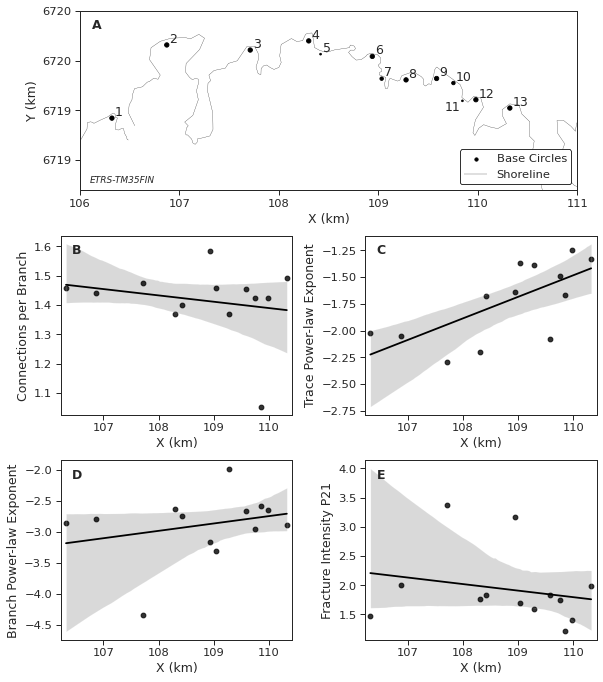

In [20]:
fig = plt.figure(constrained_layout=True, figsize=utils.paper_figsize(0.8))

gs = fig.add_gridspec(3, 2)

fig_top_ax = fig.add_subplot(gs[0, :])
fig_left_middle = fig.add_subplot(gs[1, 0])
fig_right_middle = fig.add_subplot(gs[1, 1])
fig_left_bot = fig.add_subplot(gs[2, 0])
fig_right_bot = fig.add_subplot(gs[2, 1])


fig_top_ax = plotting_utils.plot_base_circle_map(
    filtered=filtered, shoreline=shoreline, ax=fig_top_ax
)

fig_top_ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func_m_to_km))
fig_top_ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func_m_to_km))

fig_top_ax.set_ylabel("Y (km)")
fig_top_ax.set_xlabel("X (km)")
fig_top_ax.legend(**{"edgecolor": "black", "loc": "lower right", "framealpha": 1})
fig_top_ax.text(0.025, 0.9, "A", transform=fig_top_ax.transAxes, fontweight="bold")
fig_top_ax.text(
    0.020,
    0.04,
    "ETRS-TM35FIN",
    transform=fig_top_ax.transAxes,
    fontsize=9,
    style="italic",
)

# fig, axes = plt.subplots(3, 2, figsize=utils.paper_figsize(1), sharex=True)
for param, ax, text in zip(
    list(utils.Utils.params_with_func)[0:4],
    [fig_left_middle, fig_right_middle, fig_left_bot, fig_right_bot],
    ("B", "C", "D", "E"),
):
    sns.regplot(data=filtered, x="x", y=param, ax=ax, ci=95, color="black")
    if param != utils.param_renamer(param):
        ax.set_ylabel(utils.param_renamer(param))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func_m_to_km))
    ax.set_xlabel("X (km)")
    ax.set_xlim(min(filtered["x"]) - 100, max(filtered["x"]) + 100)
    ax.text(0.05, 0.9, text, transform=ax.transAxes, fontweight="bold")

fig.savefig(subsampling_config.results_path / "base_circle_map.svg", bbox_inches="tight")

## Miscellaneous analyses

Simplify the significance of powerlaw vs. lognormal distribution comparison for traces.

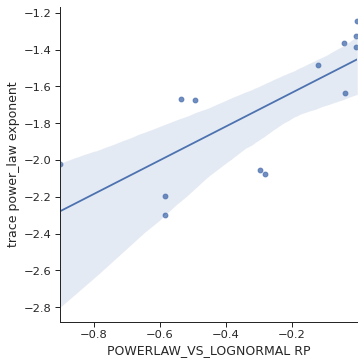

In [21]:
# Simplify significance of powerlaw vs. lognormal distribution comparison
filtered["POWERLAW_VS_LOGNORMAL RP"] = [
    val if r > 0 else -val
    for val, r in zip(
        filtered[utils.Utils.trace_power_law_vs_lognormal_p],
        filtered[utils.Utils.trace_power_law_vs_lognormal_r],
    )
]

for param in utils.Utils.params_with_func:
    sns.lmplot(
        data=filtered, x="POWERLAW_VS_LOGNORMAL RP", y="trace power_law exponent"
    )
    break

Plot RP and cut-off.

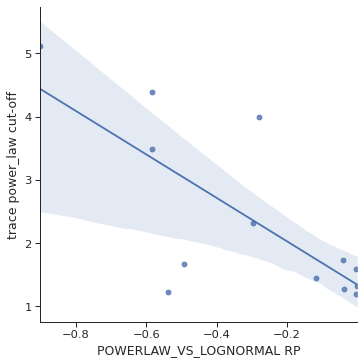

In [22]:
sns.lmplot(data=filtered, x="POWERLAW_VS_LOGNORMAL RP", y="trace power_law cut-off")

Simplify the significance of powerlaw vs. lognormal distribution comparison for branches.

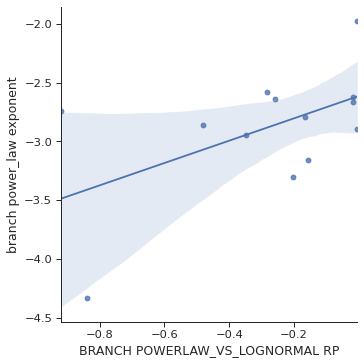

In [23]:
# Simplify significance of powerlaw vs. lognormal distribution comparison
filtered["BRANCH POWERLAW_VS_LOGNORMAL RP"] = [
    val if r > 0 else -val
    for val, r in zip(
        filtered[utils.Utils.trace_power_law_vs_lognormal_p.replace("trace", "branch")],
        filtered[utils.Utils.trace_power_law_vs_lognormal_r.replace("trace", "branch")],
    )
]

for param in utils.Utils.params_with_func:
    sns.lmplot(
        data=filtered,
        x="BRANCH POWERLAW_VS_LOGNORMAL RP",
        y="branch power_law exponent",
    )
    break

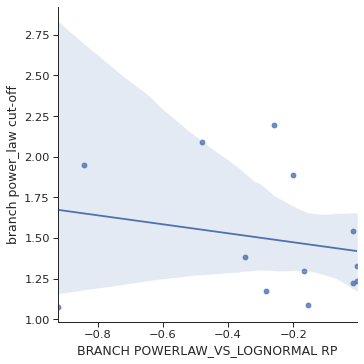

In [24]:
sns.lmplot(
    data=filtered, x="BRANCH POWERLAW_VS_LOGNORMAL RP", y="branch power_law cut-off"
)

In [25]:
filtered["branch lognormal vs. exponential R"], filtered[
    "branch lognormal vs. exponential p"
]
# filtered.columns

(1     0.876708
 2     1.225973
 3     0.667302
 4     1.415927
 5     1.801223
 6     2.777764
 12    1.957473
 13    2.542145
 14    1.046628
 15    2.034581
 16    1.193184
 17    1.446944
 18    0.471044
 Name: branch lognormal vs. exponential R, dtype: float64,
 1     0.380645
 2     0.220209
 3     0.504579
 4     0.156797
 5     0.071668
 6     0.005473
 12    0.050292
 13    0.011017
 14    0.295271
 15    0.041893
 16    0.232797
 17    0.147913
 18    0.637609
 Name: branch lognormal vs. exponential p, dtype: float64)

In [26]:
filtered[["radius", "name"]]

,radius,name
1,25.0,Getaberget_20m_1_1_area
2,20.0,Getaberget_20m_1_2_area
3,10.0,Getaberget_20m_1_3_area
4,25.0,Getaberget_20m_1_4_area
5,20.0,Getaberget_20m_2_1_area
6,25.0,Getaberget_20m_2_2_area
12,25.0,Getaberget_20m_4_3_area
13,25.0,Getaberget_20m_5_1_area
14,25.0,Getaberget_20m_7_1_area
15,10.0,Getaberget_20m_7_2_area
